In [16]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

In [17]:
# 1. Paths
data_dir = Path(r"C:\Users\Raghav Singla\Desktop\PBL-4")
train_fp = data_dir / "UNSW_NB15_training-set.csv"
test_fp  = data_dir / "UNSW_NB15_testing-set.csv"

In [18]:
# 2. Load
df_train = pd.read_csv(train_fp)
df_test  = pd.read_csv(test_fp)

In [19]:
drop_cols = ["id", "attack_cat"]
X_train = df_train.drop(columns=drop_cols + ["label"])
y_train = df_train["label"]
X_test  = df_test.drop(columns=drop_cols + ["label"])
y_test  = df_test["label"]


In [20]:
# 4. Label‐encode categoricals
cat_cols = ["proto", "service", "state"]
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]]).astype(str)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col]  = le.transform(X_test[col].astype(str))

In [21]:
# 5. Numeric coercion + missing‐value imputation
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test  = X_test.apply(pd.to_numeric, errors="coerce")
medians = X_train.median()
X_train.fillna(medians, inplace=True)
X_test.fillna(medians, inplace=True)


In [22]:
# 6. Display dataset info
print("=== TRAIN SET INFO ===")
print(X_train.shape)
print(X_train.info())
print("\n=== TEST SET INFO ===")
print(X_test.shape)
print(X_test.info())
print("\n=== LABEL DISTRIBUTIONS ===")
print("Train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Test: ", y_test.value_counts(normalize=True).round(3).to_dict())

=== TRAIN SET INFO ===
(175341, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  int32  
 2   service            175341 non-null  int32  
 3   state              175341 non-null  int32  
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt         

In [23]:
results = []  # Shared results list for comparison later


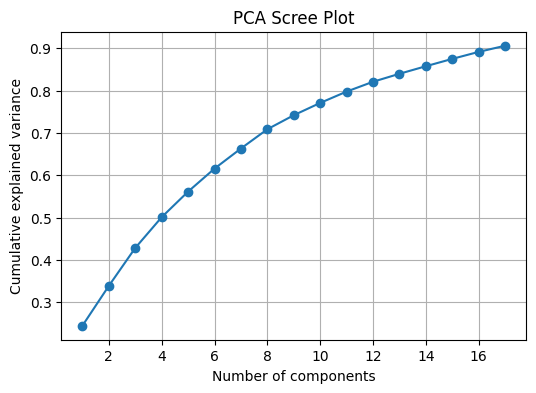

Number of components to reach 90% variance: 17


In [24]:
# === My new cell ===
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Standardize the training features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 2. Fit PCA retaining enough components to explain ~90% variance
pca = PCA(n_components=0.90, svd_solver="full", random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. Scree plot of explained variance ratio
plt.figure(figsize=(6,4))
plt.plot(
    range(1, len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_ratio_.cumsum(),
    marker="o"
)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

print(f"Number of components to reach 90% variance: {pca.n_components_}")



In [25]:
# === My new cell ===
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize and fit PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(random_state=42)
pca.fit(X_scaled)

# 2. Collect explained variances
pc_names = [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))]
var_ratios = pca.explained_variance_ratio_

# 3. Compute loadings and find top feature per PC
loadings = pd.DataFrame(
    pca.components_, columns=X_train.columns, index=pc_names
)
top_features = loadings.abs().idxmax(axis=1)

# 4. Build summary DataFrame and sort by variance
summary = pd.DataFrame({
    "Component": pc_names,
    "Explained Variance": var_ratios,
    "Top Feature": top_features
})
summary = summary.sort_values("Explained Variance", ascending=False).reset_index(drop=True)

# 5. Display
print(summary)


   Component  Explained Variance        Top Feature
0        PC1        2.445230e-01               dwin
1        PC2        9.413791e-02              dpkts
2        PC3        8.959863e-02              dpkts
3        PC4        7.263860e-02             sbytes
4        PC5        6.044675e-02             dbytes
5        PC6        5.431044e-02             sinpkt
6        PC7        4.746665e-02       is_ftp_login
7        PC8        4.549553e-02               sjit
8        PC9        3.316248e-02            service
9       PC10        2.903784e-02              sload
10      PC11        2.679803e-02                dur
11      PC12        2.317811e-02              smean
12      PC13        1.886043e-02        trans_depth
13      PC14        1.786965e-02               djit
14      PC15        1.734123e-02                dur
15      PC16        1.653141e-02  response_body_len
16      PC17        1.452947e-02            service
17      PC18        1.334002e-02                dur
18      PC19

In [26]:
# === My new cell ===
# Path 2: PCA-based feature selection (fixing the X_train_s undefined error)

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1) Standardize the features first
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
# (Optionally standardize X_test if you’ll use it later)
# X_test_s = scaler.transform(X_test)

# 2a) Fit full PCA to get loadings & explained variances
pca_full = PCA(random_state=42)
pca_full.fit(X_train_s)
loadings = pca_full.components_           # shape (n_components, n_features)
vars_rat  = pca_full.explained_variance_ratio_

# 2b) Compute PCA-importance per feature
#     score_i = sum_k (vars_rat[k] * loading[k, i]^2)
scores = np.sum((loadings**2).T * vars_rat, axis=1)
score_s  = pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

# 2c) Select top-10 features
top_feats = score_s.head(10).index.tolist()
print("Top 10 PCA-selected features:", top_feats)

# 2d) Retrain & evaluate a RandomForest on those features
X_tr_sel = X_train[top_feats]
X_te_sel = X_test[top_feats]

rf_sel = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
)
rf_sel.fit(X_tr_sel, y_train)
y_pred2 = rf_sel.predict(X_te_sel)

print("\nClassification Report on PCA-selected features:")
print(classification_report(y_test, y_pred2, digits=4))


Top 10 PCA-selected features: ['proto', 'dur', 'state', 'smean', 'sttl', 'dpkts', 'ackdat', 'synack', 'response_body_len', 'djit']

Classification Report on PCA-selected features:
              precision    recall  f1-score   support

           0     0.9548    0.7413    0.8346     37000
           1     0.8215    0.9714    0.8901     45332

    accuracy                         0.8680     82332
   macro avg     0.8881    0.8563    0.8624     82332
weighted avg     0.8814    0.8680    0.8652     82332



In [27]:
# === My new cell ===
# 7. Hyperparameter tuning on PCA‐selected features
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_base = RandomForestClassifier(class_weight="balanced", random_state=42)
rand_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rand_search.fit(X_tr_sel, y_train)

print("🔍 Best hyperparameters:", rand_search.best_params_)
best_rf = rand_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# === My new cell ===
# 8. Final evaluation of tuned RF on PCA‐selected features
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Predict labels and probabilities
y_pred = best_rf.predict(X_te_sel)
y_prob = best_rf.predict_proba(X_te_sel)[:, 1]

# 8a) Print detailed classification metrics
print("=== Final Tuned RF Performance ===")
print(classification_report(y_test, y_pred, digits=4))

# 8b) Plot ROC curve with AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned RF on PCA-Selected Features")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# === My new cell ===
# 9d. Fit the pipeline on training data, then persist pipeline + threshold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import json

# Top‐10 PCA‐selected features
top_feats = [
    'proto','dur','state','smean','sttl',
    'dpkts','ackdat','synack','response_body_len','djit'
]

# 1) ColumnTransformer to pick only those columns
selector = ColumnTransformer(
    [("select", "passthrough", top_feats)],
    remainder="drop"
)

# 2) Pipeline: selector → tuned RandomForest
pipeline = Pipeline([
    ("select", selector),
    ("rf", best_rf)
])

# 3) Fit the pipeline on the training set
pipeline.fit(X_train[top_feats], y_train)

# 4) Persist the fitted pipeline
joblib.dump(pipeline, "ids_pipeline.pkl")
print("✔ Fitted pipeline saved as ids_pipeline.pkl")

# 5) Persist the optimal decision threshold
with open("threshold.json", "w") as f:
    json.dump({"threshold": float(opt_thresh)}, f)
print(f"✔ Threshold ({opt_thresh:.3f}) saved in threshold.json")


In [ ]:
# === My new cell ===
# 10. Feature importances from the pipeline’s RandomForest model

import pandas as pd
import matplotlib.pyplot as plt

# List of PCA‐selected features in the pipeline
top_feats = [
    'proto','dur','state','smean','sttl',
    'dpkts','ackdat','synack','response_body_len','djit'
]

# Extract the fitted RandomForest from the pipeline
rf_in_pipeline = pipeline.named_steps['rf']

# Build a Series of importances indexed by your top_feats
importances = pd.Series(
    rf_in_pipeline.feature_importances_,
    index=top_feats
)

# Sort descending and display
importances = importances.sort_values(ascending=False)
print("Feature importances (pipeline RF):")
print(importances)

# Visualize all 10
plt.figure(figsize=(8,5))
importances.plot.barh()
plt.gca().invert_yaxis()
plt.title("Feature Importances from Tuned RF on PCA‐Selected Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
# # === My new cell ===
# # 4. Identify top features by absolute loading for first 3 PCs
# loadings = pd.DataFrame(
#     pca.components_,
#     columns=X_train.columns,
#     index=[f"PC{i+1}" for i in range(pca.n_components_)]
# )

# for pc in ["PC1","PC2","PC3"]:
#     sorted_loadings = loadings.loc[pc].abs().sort_values(ascending=False)
#     top_feats = sorted_loadings.head(5).index.tolist()
#     print(f"{pc} top 5 features: {top_feats}")


## Random Forest


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

results.append({
    "Model": "RandomForest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-Score": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_prob_rf),
})

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

results.append({
    "Model": "KNN",
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1-Score": f1_score(y_test, y_pred_knn),
    "ROC AUC": roc_auc_score(y_test, y_prob_knn),
})

print("K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1-Score:", f1_score(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn))


In [ ]:
# from sklearn.svm import SVC

# svm = SVC(kernel="rbf", C=1.0, probability=True, random_state=42)
# svm.fit(X_train, y_train)
# y_pred_svm = svm.predict(X_test)
# y_prob_svm = svm.predict_proba(X_test)[:, 1]

# results.append({
#     "Model": "SVM",
#     "Accuracy": accuracy_score(y_test, y_pred_svm),
#     "Precision": precision_score(y_test, y_pred_svm),
#     "Recall": recall_score(y_test, y_pred_svm),
#     "F1-Score": f1_score(y_test, y_pred_svm),
#     "ROC AUC": roc_auc_score(y_test, y_prob_svm),
# })

# print("Support Vector Machine")
# print("Accuracy:", accuracy_score(y_test, y_pred_svm))
# print("Precision:", precision_score(y_test, y_pred_svm))
# print("Recall:", recall_score(y_test, y_pred_svm))
# print("F1-Score:", f1_score(y_test, y_pred_svm))
# print("ROC AUC:", roc_auc_score(y_test, y_prob_svm))


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

results.append({
    "Model": "LogisticRegression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1-Score": f1_score(y_test, y_pred_lr),
    "ROC AUC": roc_auc_score(y_test, y_prob_lr),
})

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
y_prob_ada = ada.predict_proba(X_test)[:, 1]

results.append({
    "Model": "AdaBoost",
    "Accuracy": accuracy_score(y_test, y_pred_ada),
    "Precision": precision_score(y_test, y_pred_ada),
    "Recall": recall_score(y_test, y_pred_ada),
    "F1-Score": f1_score(y_test, y_pred_ada),
    "ROC AUC": roc_auc_score(y_test, y_prob_ada),
})

print("AdaBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("Precision:", precision_score(y_test, y_pred_ada))
print("Recall:", recall_score(y_test, y_pred_ada))
print("F1-Score:", f1_score(y_test, y_pred_ada))
print("ROC AUC:", roc_auc_score(y_test, y_prob_ada))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create and display comparison table
metrics_df = pd.DataFrame(results).set_index("Model").round(4)
print("=== MODEL PERFORMANCE COMPARISON ===")
display(metrics_df)

# Plot Accuracy vs F1-Score
metrics_df[["Accuracy", "F1-Score"]].plot(kind="bar", ylim=(0, 1), rot=45, figsize=(10, 5))
plt.title("Model Comparison: Accuracy vs F1-Score")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


In [ ]:
# import joblib

# # 1. Pick best model name by F1-Score
# best_name = metrics_df["F1-Score"].idxmax()
# print(f"🔹 Best model: {best_name}")

# # 2. Match best_name to the corresponding trained model variable
# if best_name == "RandomForest":
#     best_model = rf
# elif best_name == "KNN":
#     best_model = knn
# elif best_name == "SVM":
#     best_model = svm
# elif best_name == "LogisticRegression":
#     best_model = lr
# elif best_name == "AdaBoost":
#     best_model = ada
# else:
#     raise ValueError("Model name not recognized!")

# # 3. Save model to file
# joblib.dump(best_model, f"{best_name.lower()}_best_model.joblib")
# print(f"✔ Saved to {best_name.lower()}_best_model.joblib")


In [ ]:
# # === My new cell ===
# # 14. Determine optimal decision threshold from ROC
# import numpy as np
# from sklearn.metrics import roc_curve

# # Get the positive-class probabilities
# y_scores = best_model.predict_proba(X_test)[:, 1]

# # Compute ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# # Choose threshold that maximizes TPR − FPR
# opt_idx = np.argmax(tpr - fpr)
# opt_threshold = thresholds[opt_idx]
# print(f"🎯 Optimal threshold ≈ {opt_threshold:.3f}")


In [ ]:
# # === My new cell ===
# # 15. Export the best model to ONNX + dump feature list
# from skl2onnx import convert_sklearn
# from skl2onnx.common.data_types import FloatTensorType
# import json

# # ONNX export
# initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
# onnx_model = convert_sklearn(best_model, initial_types=initial_type)
# with open(f"{best_name.lower()}.onnx", "wb") as f:
#     f.write(onnx_model.SerializeToString())
# print(f"✔ Exported ONNX model: {best_name.lower()}.onnx")

# # Feature list for JS extractor
# feature_names = X_train.columns.tolist()
# with open("feature_list.json", "w") as f:
#     json.dump(feature_names, f, indent=2)
# print("✔ Saved feature_list.json")


In [ ]:
# # === My new cell ===
# import m2cgen as m2c
# import joblib

# print("Check 1")

# # Load your best model
# best_model = joblib.load("randomforest_best_model.joblib")

# # Export to JS
# js_code = m2c.export_to_javascript(best_model)

# # Save to a .js file you can import in your extension
# with open("model.js", "w") as f:
#     f.write(js_code)

# print("✔ Generated model.js for direct browser inference")


In [ ]:
# # === My new cell ===
# import m2cgen as m2c
# from sklearn.linear_model import LogisticRegression
# import joblib

# # 1. Train a lightweight logistic model
# lr_small = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
# lr_small.fit(X_train, y_train)

# # 2. Save for Python
# joblib.dump(lr_small, "logreg_small.joblib")

# # 3. Export to JS
# js_code = m2c.export_to_javascript(lr_small)
# with open("model_logreg.js", "w") as f:
#     f.write(js_code)

# print("✔ Exported logistic regression to model_logreg.js")
